In [2]:
# Import dependencies
import numpy as np
import pandas as pd
from collections import Counter
import statistics
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


In [3]:

# entropy function as a global function
def entropy(y):
    # calculate the number of occurences of all class labels
    hist = np.bincount(y)
    ps = hist/ len(y)
    # apply the formula for entropy
    return -np.sum([p*np.log2(p) for p in ps if p>0])

# gini as a global function
def gini(y):
    unique,count = np.unique(y,return_counts=True)
    tmp = 0
    for i in unique:
        tmp += (count[unique==i]/np.sum(count))**2
    return 1-tmp

# a helper class to store information of the node
class Node:
    def __init__(self, feature=None, threshold=None,left=None,right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    # a helper function to determine if we are at the leafnode
    def is_leaf_node(self):
        return self.value is not None
# decision tree class
class ScratchDecesionTreeClassifierDepth1():
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        # a root so that we can know where we started
        self.root = None
        
    def fit(self, X,y):
        # grow tree
        # apply a safety check
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)
        
    # function to grow the tree
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        # apply the stopping criteria of our growing tree
        if(depth >= self.max_depth
          or n_labels == 1
          or n_samples < self.min_samples_split):
            # if the condition is true that would mean that we are at the leaf node
            # check for the common label in our node
            leaf_value = self._most_common_label(y)
            # use our class to store the node information
            return Node(value=leaf_value)
        
        # if we did not meet the stopping criteria
        feat_idxs = np.random.choice(n_features, self.n_feats,replace=False)
        
        # do a greedy search
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:,best_feat], best_thresh)
        
        # continue growing
        left = self._grow_tree(X[left_idxs,:], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs,:], y[right_idxs], depth+1)
        
        node = Node(best_feat, best_thresh, left, right)
        return node

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idxs, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            # lets go over all threshold
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                # calculating the information gain
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return split_idx, split_thresh
    
    # a function to calculate the information gain
    def _information_gain(self, y, X_column, split_thresh):
        # calculate the parent entropy
        parent_gini = gini(y)
        
        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        
        if len(left_idxs) == 0 or len(right_idxs)==0:
            return 0

        # calculate the weighted average child entropy
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_g, e_g = gini(y[left_idxs]), gini(y[right_idxs])
        child_gini = (n_l/n) * e_g + (n_r/n) *e_g
        
        # calculating the information gain
        ig = parent_gini - child_gini
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs
    
    def predict(self, X):
        # traverse our tree
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    # a function helper for prediction
    def _traverse_tree(self, x, node):
        # check for the stopping criteria
        if node.is_leaf_node():
            return node.value
        # check if we go from left or right
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    
    # function to check the common label in our node
    def _most_common_label(self, y):
        # calculating the number of occurencies in y using counter
        counter = Counter(y)
        # getting the value of the most common label
        most_common = counter.most_common(1)[0][0]
        return most_common

data = datasets.load_breast_cancer()
X = data.data
y = data.target

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# training our classifier
clf = ScratchDecesionTreeClassifierDepth1(max_depth=2)
clf.fit(X_train, y_train)

# predicting
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('accuracy',accuracy)
print('precision',precision)
print('recall',recall)
print('f1',f1)


accuracy 0.8070175438596491
precision 0.7640449438202247
recall 0.9855072463768116
f1 0.8607594936708861


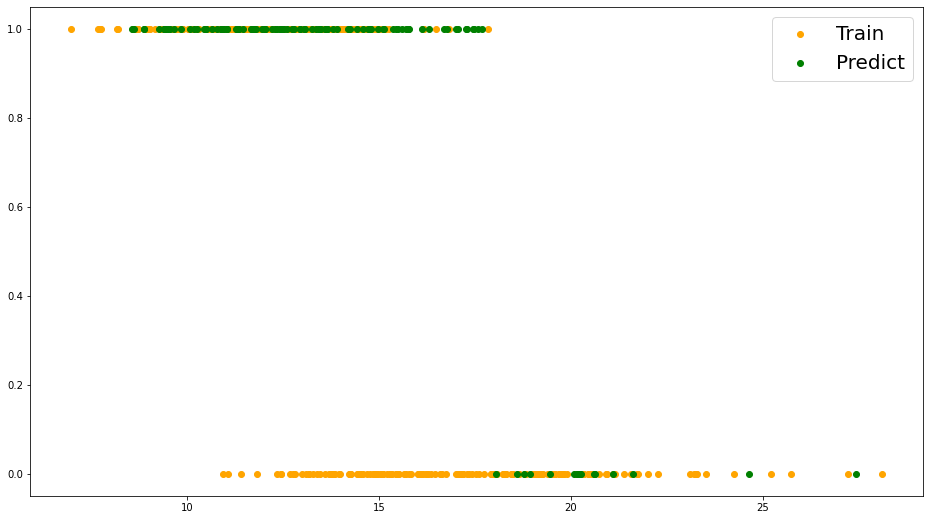

In [4]:

# training our classifier
clf_1 = ScratchDecesionTreeClassifierDepth1(max_depth=1)
clf_1.fit(X_train, y_train)

# predicting
y_pred_1 = clf_1.predict(X_test)

fig,ax = plt.subplots(figsize=(16,9))

plt.rcParams["font.size"] = 20
plt.scatter(X_train[:,0],y_train,label="Train", c="orange")
plt.scatter(X_test[:,0],y_pred_1,label="Predict", c="green")
plt.legend()
plt.plot();

In [5]:

model = ScratchDecesionTreeClassifierDepth1()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(y_pred)

[1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1
 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1
 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0
 1 0 0]


In [6]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('accuracy',accuracy)
print('precision',precision)
print('recall',recall)
print('f1',f1)

accuracy 0.8859649122807017
precision 0.85
recall 0.9855072463768116
f1 0.912751677852349


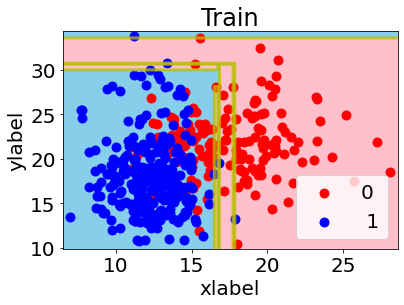

In [7]:

clf_2 = ScratchDecesionTreeClassifierDepth1(max_depth=10)
clf_2.fit(X_train[:,:2], y_train)

# Visualise the decision area
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()
    
decision_region(X_train[:,:2],y_train,clf_2,title='Train',target_names=['0', ' 1'])

In [8]:

class DecisionTreeNode():
    """
    Data structure to represent a node in a decision tree
    """
    def __init__(self, verbose=False,max_depth=None):
        self.verbose = verbose
        self.max_depth = max_depth   
    def _tree_contruct(self,X,y,depth=None):
        """
        Determine the split and generate two node left and right
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        """
        
        if len(np.unique(y)) == 1 or depth == self.max_depth:
            self.label = statistics.mode(y)
            return
            
        number_of_features = X.shape[1]
        self.best_gain = 0
        for i in range(number_of_features):
            candidate_threshold = np.unique(X[:,i])
            
            for threshold in candidate_threshold:
                left = y[X[:,i] < threshold]
                right = y[X[:,i] >= threshold]
                
                split_info_gain = self._information_gain(y,left,right)
                
                if split_info_gain > self.best_gain:
                    self.threshold = threshold
                    self.feature_chosen = i
                    self.best_gain = split_info_gain
                    
                    if self.verbose:
                        print("depth: {}, feature: {}, information_gain: {}".format(depth,self.feature_chosen,self.best_gain))
                        
        self.label = None
        self.left_node = DecisionTreeNode(verbose=self.verbose, max_depth=self.max_depth)
        self.left_node._tree_contruct(X=X[X[:,self.feature_chosen] < self.threshold],y=y[X[:,self.feature_chosen] < self.threshold],depth=depth+1)
        self.right_node = DecisionTreeNode(verbose=self.verbose,  max_depth=self.max_depth)
        self.right_node._tree_contruct(X=X[X[:,self.feature_chosen] >= self.threshold],y=y[X[:,self.feature_chosen] >= self.threshold],depth=depth+1)
        
        
    def predict(self, X):
        """
        Estimate the label of a sample by traverse node in a decision tree classifier
        """
        if self.label is None:
            if X[self.feature_chosen] < self.threshold:
                return self.left_node.predict(X)
            else:
                return self.right_node.predict(X)
        else:
            return self.label
        
    def _gini(self,node):
        """
        Function to calculate gini impurity of a node
        Parameters
        -------
        node: nd_array shape(n_smaples,1)
        Output
        --------
        Gini impurity of a node
        """
        samples,counts = np.unique(node, return_counts=True)
        result = 1
        node_count = len(node)
        for count in counts:
            result -= (count / node_count)**2
        return result
    def _information_gain(self, parent, left, right):
        """
        Calculate information gain of a specific division using gini impurity
        Parameters
        ---------
        parent, left,right: parent, left, right node of the split, ndarray shape (number_of_samples,1)
        Output
        ---------
        Information gain of the division
        """
        parent_gini = self._gini(parent)
        left_gini = (self._gini(left) * len(left)) / len(parent)
        right_gini = (self._gini(right) * len(right)) / len(parent)
        return parent_gini - left_gini - right_gini

class ScratchDecesionTreeClassifierDepth2():
    """
    Decision tree classifier scratch implementation
    Parameters
    ----------
    verbose : bool
      True to output the learning process
    """
    def __init__(self, verbose=False,max_depth=None):
        # Record hyperparameters as attributes
        self.verbose = verbose
        self.max_depth = max_depth
    def fit(self, X, y):
        """
        Learn the decision tree classifier
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        """
        self.root = DecisionTreeNode(verbose=self.verbose,max_depth=self.max_depth)
        self.root._tree_contruct(X,y,0)
        
        
    def predict(self, X):
        """
        Estimate the label using a decision tree classifier
        """
        result = np.zeros(len(X))
        for i,sample in enumerate(X):
            result[i] = self.root.predict(sample)
        return result

model = ScratchDecesionTreeClassifierDepth2(verbose=True,max_depth=2)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('accuracy',accuracy)
print('precision',precision)
print('recall',recall)
print('f1',f1)


depth: 0, feature: 0, information_gain: 0.000593450215370106
depth: 0, feature: 0, information_gain: 0.0011895205199914383
depth: 0, feature: 0, information_gain: 0.0017882283038366253
depth: 0, feature: 0, information_gain: 0.002389591111113476
depth: 0, feature: 0, information_gain: 0.002993626641978331
depth: 0, feature: 0, information_gain: 0.0036003527542722846
depth: 0, feature: 0, information_gain: 0.0042097874652820555
depth: 0, feature: 0, information_gain: 0.004821948953522059
depth: 0, feature: 0, information_gain: 0.005436855560543574
depth: 0, feature: 0, information_gain: 0.006054525792764998
depth: 0, feature: 0, information_gain: 0.006674978323329972
depth: 0, feature: 0, information_gain: 0.007298231993987603
depth: 0, feature: 0, information_gain: 0.00792430581700132
depth: 0, feature: 0, information_gain: 0.008553218977080723
depth: 0, feature: 0, information_gain: 0.009184990833342455
depth: 0, feature: 0, information_gain: 0.009819640921295558
depth: 0, feature: 0,

In [9]:
model = ScratchDecesionTreeClassifierDepth2(verbose=True)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('accuracy',accuracy)
print('precision',precision)
print('recall',recall)
print('f1',f1)

depth: 0, feature: 0, information_gain: 0.000593450215370106
depth: 0, feature: 0, information_gain: 0.0011895205199914383
depth: 0, feature: 0, information_gain: 0.0017882283038366253
depth: 0, feature: 0, information_gain: 0.002389591111113476
depth: 0, feature: 0, information_gain: 0.002993626641978331
depth: 0, feature: 0, information_gain: 0.0036003527542722846
depth: 0, feature: 0, information_gain: 0.0042097874652820555
depth: 0, feature: 0, information_gain: 0.004821948953522059
depth: 0, feature: 0, information_gain: 0.005436855560543574
depth: 0, feature: 0, information_gain: 0.006054525792764998
depth: 0, feature: 0, information_gain: 0.006674978323329972
depth: 0, feature: 0, information_gain: 0.007298231993987603
depth: 0, feature: 0, information_gain: 0.00792430581700132
depth: 0, feature: 0, information_gain: 0.008553218977080723
depth: 0, feature: 0, information_gain: 0.009184990833342455
depth: 0, feature: 0, information_gain: 0.009819640921295558
depth: 0, feature: 0,